***NOTE: We Used NoNorm Values Generated by Chris for the paper**** (Can be found at the bottom of this)
I have been using my own MNI disconnectomes nonorm values from here on out

In [ ]:
import nibabel as nb
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from glob import glob
from nilearn import masking, mass_univariate, plotting
from nilearn.masking import unmask
from nilearn.input_data import NiftiMasker
import nilearn.maskers
import matplotlib.pyplot as plt
import os
from os.path import join
import math

In [ ]:
###Checking nilearn version
import nilearn
print(nilearn.__version__)

In [ ]:
vgrdemo = pd.read_csv("/data/neuralabc/stechr/STROMAP_CLSM/processing/behaviour/bx_VGR_aff_unaff.csv", index_col=None, header=0)
vgrdemo

**APM Regression - with Affected hand**

In [2]:
####Loading disconnectomes for APM and masks

#Insert which subjects you'd like to take out here: 
pRemove = {'S02','S06', 'S15', 'S40'}

##Create a set out of all the subject files
fnames = set(glob("/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/disconnectomes/HCP_model_N1001_seed_dynamic_100M_SIFT_10M_to_MNI-S*_lesion_mask_MNI152_INT8*_tdi_fraction-count-disconnect_proportion.nii.gz"))
#Removing all the specified subjects from the set
for sub in pRemove:
    fnames = fnames-set(glob("/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/disconnectomes/HCP_model_N1001_seed_dynamic_100M_SIFT_10M_to_MNI-"+sub+"_lesion_mask_MNI152_INT8*_tdi_fraction-count-disconnect_proportion.nii.gz"))
#Sorting the files by subject number
fnames = sorted(fnames)
    
#Lab space mask for unmasking the data
# mask = "/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/MNI_42sub_disconnectome_mask.nii.gz"
len(fnames)

38

In [ ]:
##creating a custom mask for these participants, otherwise there are 0/0 errors
# Load first file to get shape, affine, header
img0 = nb.load(fnames[0])
custom_mask = np.zeros(img0.shape, dtype=np.uint8)

# Loop through subjects
for f in fnames:
    data = nb.load(f).get_fdata()
    custom_mask |= (data != 0)

# Save final binary mask
custom_img = nb.Nifti1Image(custom_mask.astype(np.uint8), affine=img0.affine, header=img0.header)
# nib.save(union_img, "union_nonzero_mask.nii.gz")
plotting.plot_stat_map(custom_img, cut_coords=(29,-6,14))

mask = custom_img

In [4]:
###Loading APM task and confound data
apmdemo = pd.read_csv("/data/neuralabc/stechr/STROMAP_CLSM/processing/behaviour/bx_APM_aff_unaff.csv", index_col=None, header=0)
apmdemoTractlas = apmdemo.set_index(apmdemo['TractLAS_ID'])
apmdemo = apmdemoTractlas.drop(index=(pRemove-{'S06', 'S15'}))
apmdemo = apmdemo.reset_index(drop=True)
apmdemo

TractLAS_ID  abs_err_XY_m_affected_hand  * - Task Score_affected_hand  \
0          S01                    0.111895                      3.288604   
1          S03                    0.077588                      1.085019   
2          S04                    0.066041                      2.036752   
3          S05                    0.077837                      2.119582   
4          S07                    0.076538                      1.088445   
5          S08                    0.083403                      1.427026   
6          S09                    0.039458                      0.058847   
7          S10                    0.036865                      0.010728   
8          S11                    0.090740                      2.687707   
9          S12                    0.065515                      1.115809   
10         S13                    0.058839                      0.607129   
11         S14                    0.042625                      0.079217   
12         S16                    0.076789                      2.007252   
13         S17                    0.139666                      3.924965   
14         S18                    0.128084                      4.123421   
15         S19                    0.080825                      1.659291   
16         S20                    0.095885                      1.958929   
17         S21                    0.060710                      0.489402   
18         S22                    0.047392                      0.463625   
19         S23                    0.069145                      1.144765   
20         S24                    0.052782                      1.585933   
21         S25                    0.060030                      1.571483   
22         S26                    0.225642                      2.874041   
23         S27                    0.046674                      0.730386   
24         S28                    0.086693                      2.410508   
25         S29                    0.097776                      1.875361   
26         S30                    0.060369                      0.554415   
27         S31                    0.162527                      5.391756   
28         S32                    0.043743                      1.133782   
29         S33                    0.074606                      1.459463   
30         S34                    0.052159                      0.532646   
31         S35                    0.047733                      0.326995   
32         S36                    0.082529                      2.300090   
33         S37                    0.107397                      3.112304   
34         S38                    0.083717                      1.526594   
35         S39                    0.132439                      2.206372   
36         S41                    0.087196                      2.649603   
37         S42                    0.132800                      2.418110   

    * - M-score_affected_hand  Z - Task Score_affected_hand  \
0                    3.323333                      3.088203   
1                    1.490898                      0.589052   
2                    1.991030                      1.731572   
3                    1.989129                      1.824459   
4                    0.729857                      0.593573   
5                    1.384983                      1.021232   
6                    0.132547                     -1.675421   
7                    0.039661                     -2.384131   
8                    2.849580                      2.447405   
9                    1.050355                      0.629522   
10                   0.476759                     -0.109924   
11                   0.080550                     -1.528939   
12                   2.205150                      1.698329   
13                   3.919091                      3.754793   
14                   4.350205                      3.960933   
15                   1.186756 

In [5]:
print('Age Mean with VGR cov',np.mean(apmdemo['Age_yrs']))
print('Age Mean with VGR cov STD',np.std(apmdemo['Age_yrs']))
print('Number of females with VGR cov',np.count_nonzero(apmdemo['Sex_m0']))
print('Age Mean with VGR cov MIN',np.min(apmdemo['Age_yrs']))
print('Age Mean with VGR cov MAX',np.max(apmdemo['Age_yrs']))

Age Mean with VGR cov 60.216654650324436
Age Mean with VGR cov STD 11.497695390446513
Number of females with VGR cov 14
Age Mean with VGR cov MIN 31.323287671232876
Age Mean with VGR cov MAX 81.16438356164383


In [6]:
vgrdemo = pd.read_csv("/data/neuralabc/stechr/STROMAP_CLSM/processing/behaviour/bx_VGR_aff_unaff.csv", index_col=None, header=0)
vgrdemoTractlas = vgrdemo.set_index(vgrdemo['TractLAS_ID'])
vgrdemo = vgrdemoTractlas.drop(index=(pRemove))
vgrdemo = vgrdemo.reset_index(drop=True)
print(np.shape(vgrdemo))
vgrdemo

(38, 17)


TractLAS_ID  * - Task Score_affected_hand  * - M-score_affected_hand  \
0          S01                      2.824341                   2.250395   
1          S03                      0.937873                   0.844787   
2          S04                      2.476494                   1.524101   
3          S05                      3.516873                   2.880176   
4          S07                      3.335334                   2.998610   
5          S08                      2.835298                   2.111747   
6          S09                      2.877079                   2.969757   
7          S10                      1.822231                   1.047066   
8          S11                      4.089770                   3.084927   
9          S12                      1.391206                   1.151591   
10         S13                      1.012181                   1.238698   
11         S14                      1.542701                   0.940301   
12         S16                      1.912743                   1.491779   
13         S17                      3.479987                   2.576192   
14         S18                      1.895061                   1.491031   
15         S19                      3.719850                   3.120203   
16         S20                      3.369199                   2.702893   
17         S21                      3.089171                   2.333309   
18         S22                      4.400687                   4.005076   
19         S23                      2.052847                   1.356841   
20         S24                      4.061297                   3.722058   
21         S25                      1.690683                   1.466178   
22         S26                      3.797138                   3.149380   
23         S27                      3.210637                   2.367821   
24         S28                      3.171165                   2.113851   
25         S29                      1.361962                   1.011174   
26         S30                      2.043949                   1.787591   
27         S31                      4.861623                   3.634995   
28         S32                      1.445403                   1.475828   
29         S33                      1.083293                   0.523906   
30         S34                      3.308467                   2.829710   
31         S35                      1.163877                   0.679515   
32         S36                      2.794704                   2.813897   
33         S37                      3.687572                   2.674064   
34         S38                      1.700425                   1.332072   
35         S39                      3.853545                   2.957050   
36         S41                      4.149876                   3.084906   
37         S42                      2.724962                   1.961265   

    Z - Task Score_affected_hand  Z - M-score_affected_hand  \
0                       2.594401                   1.969918   
1                       0.389888                   0.257932   
2                       2.218277                   1.138368   
3                       3.328444                   2.654225   
4                       3.137502                   2.780694   
5                       2.606152                   1.815701   
6                       2.650911                   2.749935   
7                       1.487663                   0.538636   
8                       3.926028                   2.872526   
9                       0.977492                   0.676098   
10                      0.491741                   0.787628   
11                      1.160595                   0.393262   
12                      1.591211                   1.099583   
13                      3.289718                   2.326741   
14                      1.571060                   1.098682   
15                      3.540954                   2.909979   
16    

In [7]:
###Setting up the confounds
confdf = pd.DataFrame({'Age':apmdemo['Age_yrs'], 'Sex':apmdemo['Sex_m0'], 'VGR':vgrdemo['* - Task Score_affected_hand']})
confdf = confdf.set_index(apmdemo['TractLAS_ID'])
#Dropping rows according to subjects needed
pList = sorted(set(apmdemo['TractLAS_ID']) - pRemove)
confdf = confdf.loc[pList]
confra = np.array(confdf)

### New array with only the Task Score of the affected hand using only subjects with available data across tasks
TS = pd.DataFrame({'Task_Score_Aff':apmdemo['* - Task Score_affected_hand']})
TS = TS.set_index(apmdemo['TractLAS_ID'])
TS = TS.loc[pList]
TSra = np.array(TS)

# ###Unmasked data as an array
lsra = np.array(ls)

confdf

Age  Sex       VGR
TractLAS_ID                          
S01          79.868493    0  2.824341
S03          67.153425    0  0.937873
S04          49.550685    1  2.476494
S05          50.241096    1  3.516873
S07          56.646575    0  3.335334
S08          59.112329    0  2.835298
S09          81.164384    1  2.877079
S10          69.153425    1  1.822231
S11          52.446575    1  4.089770
S12          67.035616    1  1.391206
S13          73.095890    0  1.012181
S14          55.687671    0  1.542701
S16          70.257534    1  1.912743
S17          66.079452    0  3.479987
S18          38.994521    0  1.895061
S19          58.487671    0  3.719850
S20          58.608219    0  3.369199
S21          61.545205    0  3.089171
S22          56.265753    1  4.400687
S23          35.172603    1  2.052847
S24          56.624658    1  4.061297
S25          49.756164    1  1.690683
S26          61.821918    0  3.797138
S27          77.575342    0  3.210637
S28          68.726027    0  3.171165
S29          53.293151    1  1.361962
S30          68.123288    0  2.043949
S31          56.926027    0  4.861623
S32          31.323288    0  1.445403
S33          60.682192    0  1.083293
S34          45.865753    1  3.308467
S35          77.309589    0  1.163877
S36          55.315068    1  2.794704
S37          73.180822    0  3.687572
S38          55.076712    0  1.700425
S39          54.715068    0  3.853545
S41          68.435616    0  4.149876
S42          66.915068    0  2.724962

In [12]:
confdf[['VGR']]
vgrdemo = pd.read_csv("/data/neuralabc/stechr/STROMAP_CLSM/processing/behaviour/bx_VGR_aff_unaff.csv", index_col=None, header=0).set_index(vgrdemo['TractLAS_ID'])
vgrdemo[['* - Task Score_affected_hand']]

* - Task Score_affected_hand
TractLAS_ID                              
S01                              2.824341
S02                                   NaN
S03                              0.937873
S04                              2.476494
S05                              3.516873
S06                              5.792452
S07                              3.335334
S08                              2.835298
S09                              2.877079
S10                              1.822231
S11                              4.089770
S12                              1.391206
S13                              1.012181
S14                              1.542701
S15                              3.782089
S16                              1.912743
S17                              3.479987
S18                              1.895061
S19                              3.719850
S20                              3.369199
S21                              3.089171
S22                              4.400687
S23                              2.052847
S24                              4.061297
S25                              1.690683
S26                              3.797138
S27                              3.210637
S28                              3.171165
S29                              1.361962
S30                              2.043949
S31                              4.861623
S32                              1.445403
S33                              1.083293
S34                              3.308467
S35                              1.163877
S36                              2.794704
S37                              3.687572
S38                              1.700425
S39                              3.853545
S40                              5.596580
S41                              4.149876
S42                              2.724962

In [138]:
print('TS mean VGR cov',np.mean(vgrdemo['* - Task Score_affected_hand']))
print('TS VGR cov STD',np.std(vgrdemo['* - Task Score_affected_hand']))
print('TS Min with VGR cov',np.min(vgrdemo['* - Task Score_affected_hand']))
print('TS Max with VGR cov',np.max(vgrdemo['* - Task Score_affected_hand']))

TS mean VGR cov 2.7024080891405653
TS VGR cov STD 1.0700050863197907
TS Min with VGR cov 0.9378731373301492
TS Max with VGR cov 4.86162332401718


In [79]:
# ###Fit the masker

# nitialize the masker with the explicit mask
oo = NiftiMasker(
    mask_img=mask,           
    standardize=False,
    smoothing_fwhm=None,
    verbose=0
)

# Fit the masker on the subject images 
oo.fit(fnames) 
# Transform the images to 2D array (subjects × voxels)
X = oo.transform(fnames)
np.shape(X)

(38, 721117)

In [80]:
#Ensure no NaNs or 0 variance voxels in arrays (this step tells you if your mask is correct for the disconnectomes)
print("TSra shape:", TSra.shape)
print("lsra shape:", X.shape)
print("TSra variance:", np.var(TSra, axis=0))
print("lsra variance:", np.var(X, axis=0))

print("TSra all zeros:", np.all(TSra == 0))
print("lsra all zeros:", np.all(X == 0))
print("TSra contains NaNs:", np.isnan(TSra).any())
print("lsra contains NaNs:", np.isnan(X).any())

print("Masker mask image shape:", oo.mask_img_.shape)
print("Masker number of voxels in mask:", np.sum(oo.mask_img_.get_fdata() > 0))

voxel_std = np.std(X, axis=0)
print("Zero-variance voxels:", np.sum(voxel_std == 0))
print("NaN voxels:", np.isnan(X).sum())

TSra shape: (38, 1)
lsra shape: (38, 721117)
TSra variance: [1.42288653]
lsra variance: [1.3819513e-01 1.3232090e-01 1.2263992e-01 ... 6.2492822e-05 6.4459920e-05
 3.7352751e-05]
TSra all zeros: False
lsra all zeros: False
TSra contains NaNs: False
lsra contains NaNs: False
Masker mask image shape: (182, 218, 182)
Masker number of voxels in mask: 721117


In [82]:
##If there are 0 variance voxels this tells you where they are
voxel_std = np.std(X, axis=0)
zero_var_indices = np.where(voxel_std == 0)[0]
print(f"Zero-variance voxels: {len(zero_var_indices)}")

zero_var_values = X[:, zero_var_indices] 

import pandas as pd

df_zero_var = pd.DataFrame(zero_var_values, columns=[f"voxel_{i}" for i in zero_var_indices])
print(df_zero_var.head())  # Shows first 5 subjects


Zero-variance voxels: 0
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [ ]:
#Checking whether the array shapes match up before inputting into the function
print(TSra.shape, X.shape, confdf.shape, X.shape)
subs = len(TSra)
print(subs)

In [ ]:
###TFCE function
#5000 permutation w covariates
n_perm = 5000

olsAPM = mass_univariate.permuted_ols(tested_vars = TSra, target_vars = X, 
                                      confounding_vars= confra, 
                                      tfce=True, n_jobs=-1, n_perm = n_perm, masker= oo, verbose=1, output_type = dict, threshold=0.05)

[Parallel(n_jobs=194)]: Using backend LokyBackend with 194 concurrent workers.


In [89]:
#what kind of results does this give?
print(olsAPM.keys())

dict_keys(['t', 'logp_max_t', 'h0_max_t', 'tfce', 'logp_max_tfce', 'h0_max_tfce', 'size', 'logp_max_size', 'h0_max_size', 'mass', 'logp_max_mass', 'h0_max_mass'])


tmin: -2.8270220120660468
tmax: 5.715334053769782


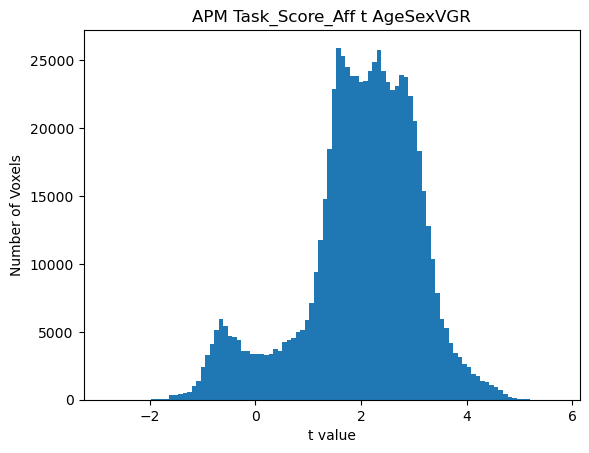

logp_max_t flip min: 0.011197760447910416
logp_max_t flip max: 1.0


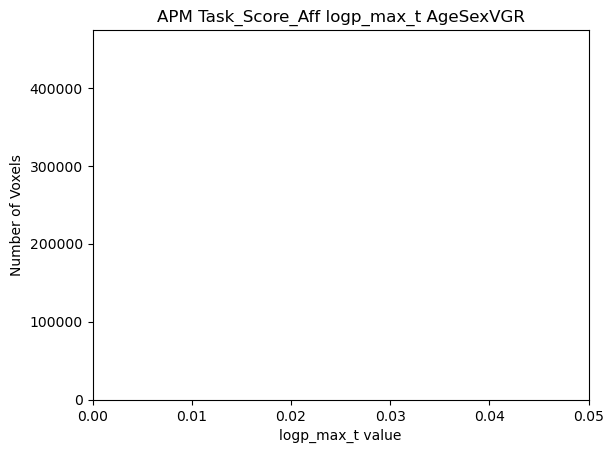

tfcemin: -820.4754942220749
tfcemax: 138495.00795546232


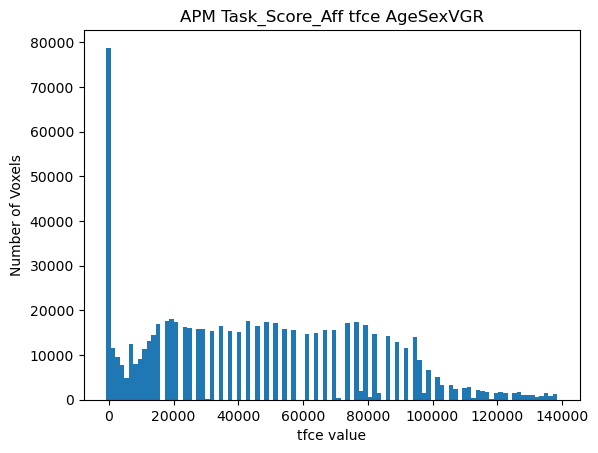

logp_max_tfce flip min: 0.003799240151969604
logp_max_tfce flip max: 1.0


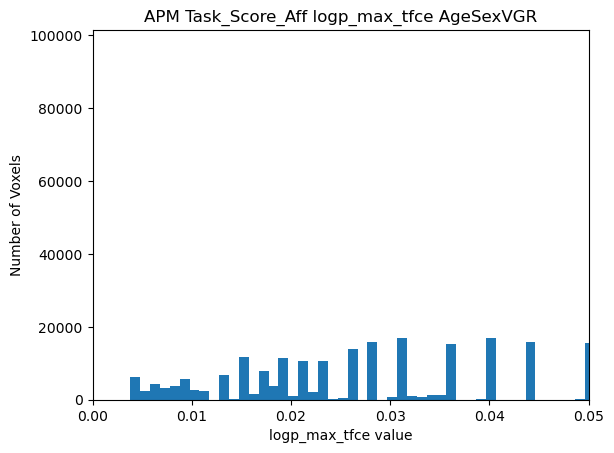

In [90]:
####Plotting regression outputs
#h0_max_t and h0_max_tfce are not volumetric and can't be saved as images (shape = 1, 10000)
volumetric_keys = ['t', 'logp_max_t', 'tfce', 'logp_max_tfce']

#Convert confounds to a string for insertion into Title
confst = ''.join(confdf.columns.values.tolist())
#Convert task metric for insertion into title
TaskMetric = ''.join(TS.columns.values)

#note: logp values are unloged to check real p value distribution

for key in volumetric_keys:
    try:
        if key in ('t'):
            plt.hist(olsAPM[(key)].flatten(), bins = 100)
            plt.title(f'APM {TaskMetric} {key} {confst}')
            plt.xlabel(f'{key} value')
            plt.ylabel('Number of Voxels')
            print(key + 'min: ' + str((olsAPM[(key)].flatten()).min()))
            print(key + 'max: ' + str((olsAPM[(key)].flatten()).max()))
        elif key in ('logp_max_t'):
            plt.hist((10**(-olsAPM[(key)].flatten())), bins = 1000)
            plt.title(f'APM {TaskMetric} {key} {confst}')
            plt.xlabel(f'{key} value')
            plt.ylabel('Number of Voxels')  
            plt.xlim(0,0.05)
            print(key + ' flip min: ' + str((10**(-olsAPM[(key)].flatten())).min()))
            print(key + ' flip max: ' + str((10**(-olsAPM[(key)].flatten())).max()))
        elif key in ('tfce'):
            plt.hist(olsAPM[(key)].flatten(), bins = 100)
            plt.title(f'APM {TaskMetric} {key} {confst}')
            plt.xlabel(f'{key} value')
            plt.ylabel('Number of Voxels')
            print(key + 'min: ' + str((olsAPM[(key)].flatten()).min()))
            print(key + 'max: ' + str((olsAPM[(key)].flatten()).max()))
        elif key in ('logp_max_tfce'):
            plt.hist((10**(-olsAPM[(key)].flatten())), bins = 1000)
            plt.title(f'APM {TaskMetric} {key} {confst}')
            plt.xlabel(f'{key} value')
            plt.ylabel('Number of Voxels')  
            plt.xlim(0,0.05)
            print(key + ' flip min: ' + str((10**(-olsAPM[(key)].flatten())).min()))
            print(key + ' flip max: ' + str((10**(-olsAPM[(key)].flatten())).max()))
        plt.show()
    except:
        print(f'{key} does not exist in this analysis')

In [92]:
###Saving all regression outputs

#Assigning output directory
out_dir='/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/'

#Convert confounds to a string for insertion into Title
confst = ''.join(confdf.columns.values.tolist())
#Convert task metric for insertion into title
TaskMetric = str(TS.columns[0])

for key in volumetric_keys:
    try:
        out_fname=join(out_dir,f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TFCE_{key}.nii.gz')# _s{str(fwhm).replace('.','p')}
        #Saving all images, if its not an image then spouts out error
        out_img = nb.save(unmask(olsAPM[(key)],mask), out_fname)
        print(out_fname)
    except:
        print(f'{key} was not an image and was therefore not saved')
    #saved in RegressionOUT


/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TFCE_t.nii.gz
/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TFCE_logp_max_t.nii.gz
/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TFCE_tfce.nii.gz
/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TFCE_logp_max_tfce.nii.gz


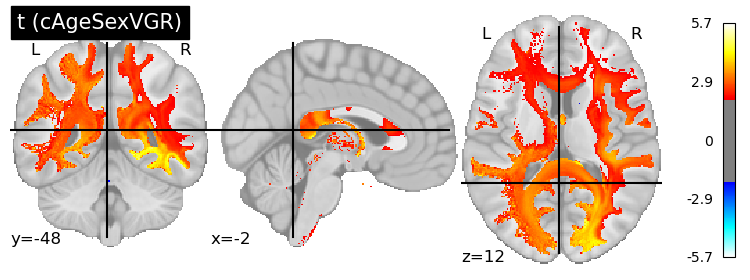

In [93]:
#Viewing t results voxel-wise
plotting.plot_stat_map((unmask(olsAPM['t'].flatten(),mask)), title='t (c' +confst + ')', threshold=2)


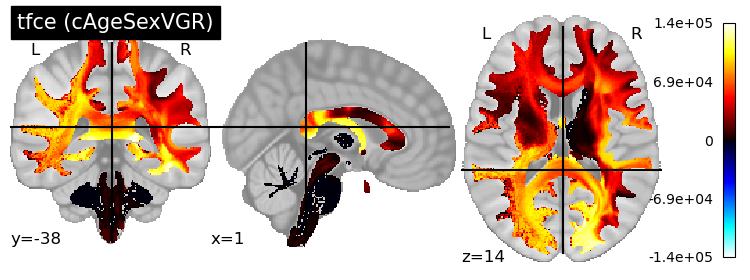

In [94]:
#Viewing tfce results voxel-wise
plotting.plot_stat_map((unmask(olsAPM['tfce'].flatten(),mask)), title='tfce (c' +confst + ')')


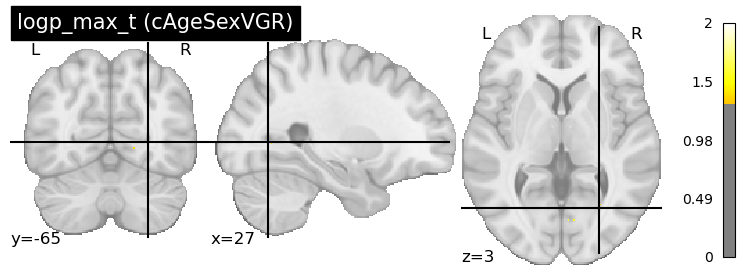

In [95]:
#Viewing pvalues of t results voxel-wise
plotting.plot_stat_map((unmask(olsAPM['logp_max_t'].flatten(),mask)), title='logp_max_t (c' +confst + ')', threshold=1.3)


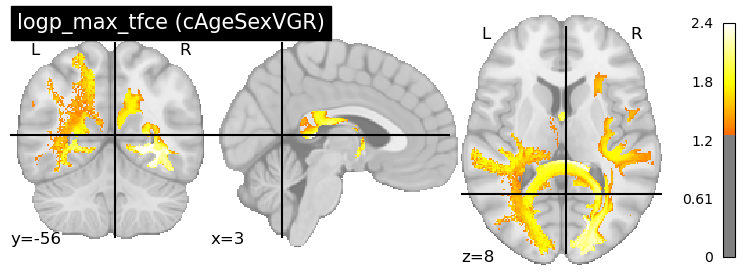

In [96]:
#Viewing pvalues of t results voxel-wise
plotting.plot_stat_map((unmask(olsAPM['logp_max_tfce'].flatten(),mask)), title='logp_max_tfce (c' +confst + ')', threshold=1.3)

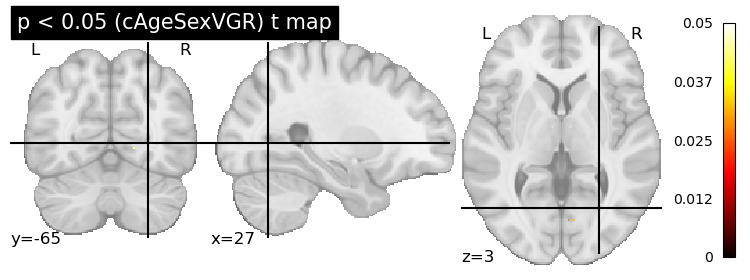

In [97]:
###Viewing only significant voxels from pure t results

#T map significance mask
# Convert -log10(p) to p-values
pvals = 10 ** (-olsAPM['logp_max_t'].flatten())
pval_img = unmask(pvals, mask)

# Plot only voxels where p ≤ 0.05 (mask out higher values manually)
import numpy as np
pvals_masked = np.where(pvals <= 0.05, pvals, 0)
pval_img_masked = unmask(pvals_masked, mask)

# Plot the masked p-values
plotting.plot_stat_map(pval_img_masked,
                       title=f'p < 0.05 (c{confst}) t map',
                       # cmap='black_red',
                       threshold=1e-10)  # just to avoid 0


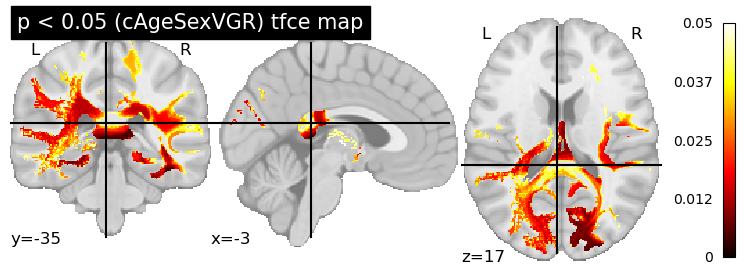

In [98]:
###Viewing only significant voxels from pure tfce results


#TFCE map significance mask

# Convert -log10(p) to p-values
pvals = 10 ** (-olsAPM['logp_max_tfce'].flatten())
pval_img = unmask(pvals, mask)

# Plot only voxels where p ≤ 0.05 (mask out higher values manually)
import numpy as np
pvals_masked = np.where(pvals <= 0.05, pvals, 0)
pval_img_masked = unmask(pvals_masked, mask)

# Plot the masked p-values
plotting.plot_stat_map(pval_img_masked,
                       title=f'p < 0.05 (c{confst}) tfce map',
                       # cmap='black_red',
                       threshold=1e-10)  # just to avoid 0


## **Only sig TFCE**

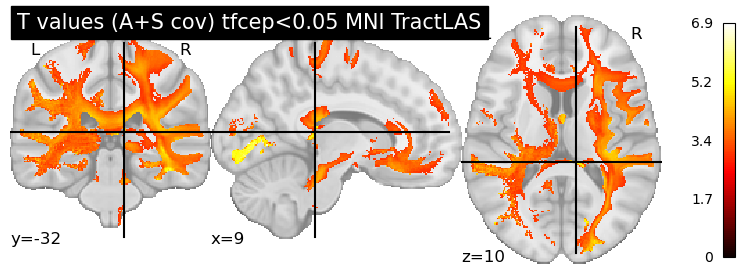

In [205]:
### Generating map where only t values deemed as significant by the tfce p values at the 0.005 level

## unmasking data to manipulate
# APMtlogp = masking.apply_mask('/data/neuralabc/kaemik/LS_StrokeDisconnect/processing/RegressionOUT/APMvsDisc_TaskScore_Affected_TFCE5000agesex_TFCElogp.nii.gz', mask)
# APMt = masking.apply_mask('/data/neuralabc/kaemik/LS_StrokeDisconnect/processing/RegressionOUT/APMvsDisc_TaskScore_Affected_TFCE5000agesex_tvals.nii.gz', mask)
# APMsigornot = np.where(olsAPM[('logp_max_tfce')]>=1.3, 1,0)
# APMtsig = APMsigornot * olsAPM[('t')]
# maskedAPMtsig  = unmask(APMtsig, mask)

# plotting.plot_stat_map(maskedAPMtsig, title='T values (A+S cov) tfcep<0.05 MNI TractLAS')


In [143]:
#Looking at the min and max tfce p values to see how far I can go
print(np.log10(0.03))
print('min: ' + str((olsAPM['logp_max_tfce'].flatten()).min()))
print('max: ' + str((olsAPM['logp_max_tfce'].flatten()).max()))

-1.5228787452803376
min: -0.0
max: 2.420303253594839


Minimum t-value non 0: 2.6862084941858213
Max t-value: 5.715334053769782


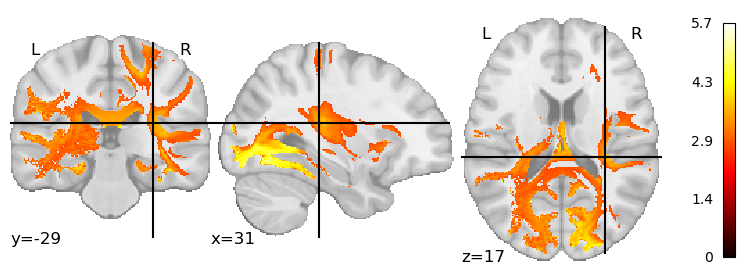

In [148]:
##create a mask of just where p vaues (I set threshold) are significant
threshold = 0.05
thresholdlog = -np.log10(threshold)
APMsigornot = np.where(olsAPM[('logp_max_tfce')]>=thresholdlog, 1,0)
#multiply the mask of significance with the tfce values so you only see tfce values when their significant 

APMtsig = APMsigornot * olsAPM[('t')]
maskedAPMtsig  = unmask(APMtsig, mask)

#Printing the minimum and Maximum non 0 t values after masking
min_nonzero = np.min(APMtsig[APMtsig > 0])
print("Minimum t-value non 0:", min_nonzero)
print("Max t-value:",np.max(APMtsig))

#Plotting the stat Map
plotting.plot_stat_map(maskedAPMtsig, cut_coords=(31,-29,17)) #title='T values (A+S+VGR cov) tfce p< '+str(threshold)+' MNI TractLAS '+str(n_perm)+'perms')
plt.show()

In [103]:
#The minimum non 0 t values after masking
np.min(min_nonzero)

2.6862084941858213

In [104]:
### Saving only significant regions of t values based on tfce p values
out_dir='/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/'

strthresh = '0p05'

nb.save(maskedAPMtsig, out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}.nii.gz')
print('Saved to: ',out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}.nii.gz')

Saved to:  /data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TonlyTFCE_0p05.nii.gz


Minimum t-value non 0: 2.9148245861715347
Max t-value: 5.715334053769782


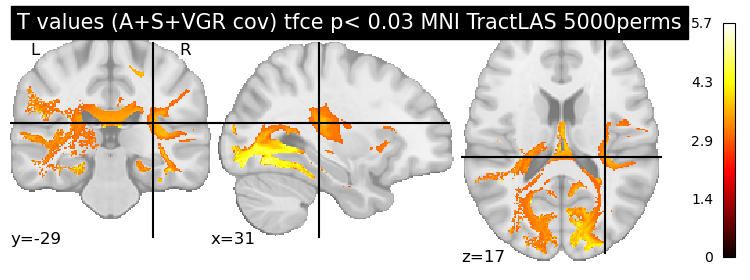

In [149]:
##create a mask of just where p vaues (I set threshold) are significant
threshold = 0.03
thresholdlog = -np.log10(threshold)
APMsigornot = np.where(olsAPM[('logp_max_tfce')]>=thresholdlog, 1,0)
##multiply the mask of significance with the tfce values so you only see tfce values when their significant 
APMtsig = APMsigornot * olsAPM[('t')]
maskedAPMtsig  = unmask(APMtsig, mask)

##Printing the minimum and Maximum non 0 t values after masking
min_nonzero = np.min(APMtsig[APMtsig > 0])
print("Minimum t-value non 0:", min_nonzero)
print("Max t-value:",np.max(APMtsig))

#Plotting the stat Map
plotting.plot_stat_map(maskedAPMtsig, title='T values (A+S+VGR cov) tfce p< '+str(threshold)+' MNI TractLAS '+str(n_perm)+'perms', cut_coords=(31,-29,17))
plt.show()


In [150]:
### Saving only significant regions of t values based on tfce p values
out_dir='/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/'

strthresh = '0p03'

nb.save(maskedAPMtsig, out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}.nii.gz')
print('Saved to: ',out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}.nii.gz')

Saved to:  /data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TonlyTFCE_0p03.nii.gz


Minimum t-value non 0: 3.5435136597301553
Max t-value: 5.715334053769782


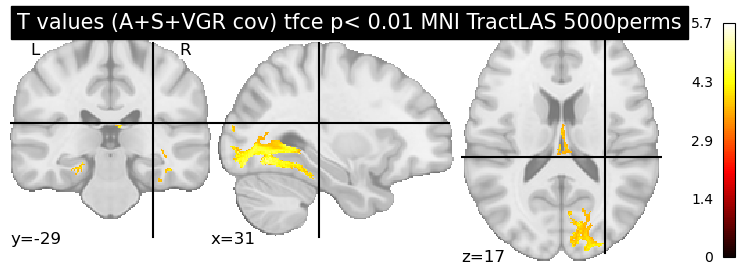

In [116]:
##create a mask of just where p vaues (I set threshold) are significant
threshold = 0.01
thresholdlog = -np.log10(threshold)
APMsigornot = np.where(olsAPM[('logp_max_tfce')]>=thresholdlog, 1,0)
##multiply the mask of significance with the tfce values so you only see tfce values when their significant 
APMtsig = APMsigornot * olsAPM[('t')]
maskedAPMtsig  = unmask(APMtsig, mask)

##Printing the minimum and Maximum non 0 t values after masking
min_nonzero = np.min(APMtsig[APMtsig > 0])
print("Minimum t-value non 0:", min_nonzero)
print("Max t-value:",np.max(APMtsig))

#Plotting the stat Map
plotting.plot_stat_map(maskedAPMtsig, title='T values (A+S+VGR cov) tfce p< '+str(threshold)+' MNI TractLAS '+str(n_perm)+'perms', cut_coords=(31,-29,17))
plt.show()


In [106]:
#The minimum non 0 t values after masking
np.min(min_nonzero)

3.5435136597301553

In [107]:
### Saving only significant regions of t values based on tfce p values
out_dir='/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/'

strthresh = '0p01'

nb.save(maskedAPMtsig, out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}.nii.gz')
print('Saved to: ',out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}.nii.gz')

Saved to:  /data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TonlyTFCE_0p01.nii.gz


/home/remoteuser/kaemik/.conda/envs/nabc_tfce/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



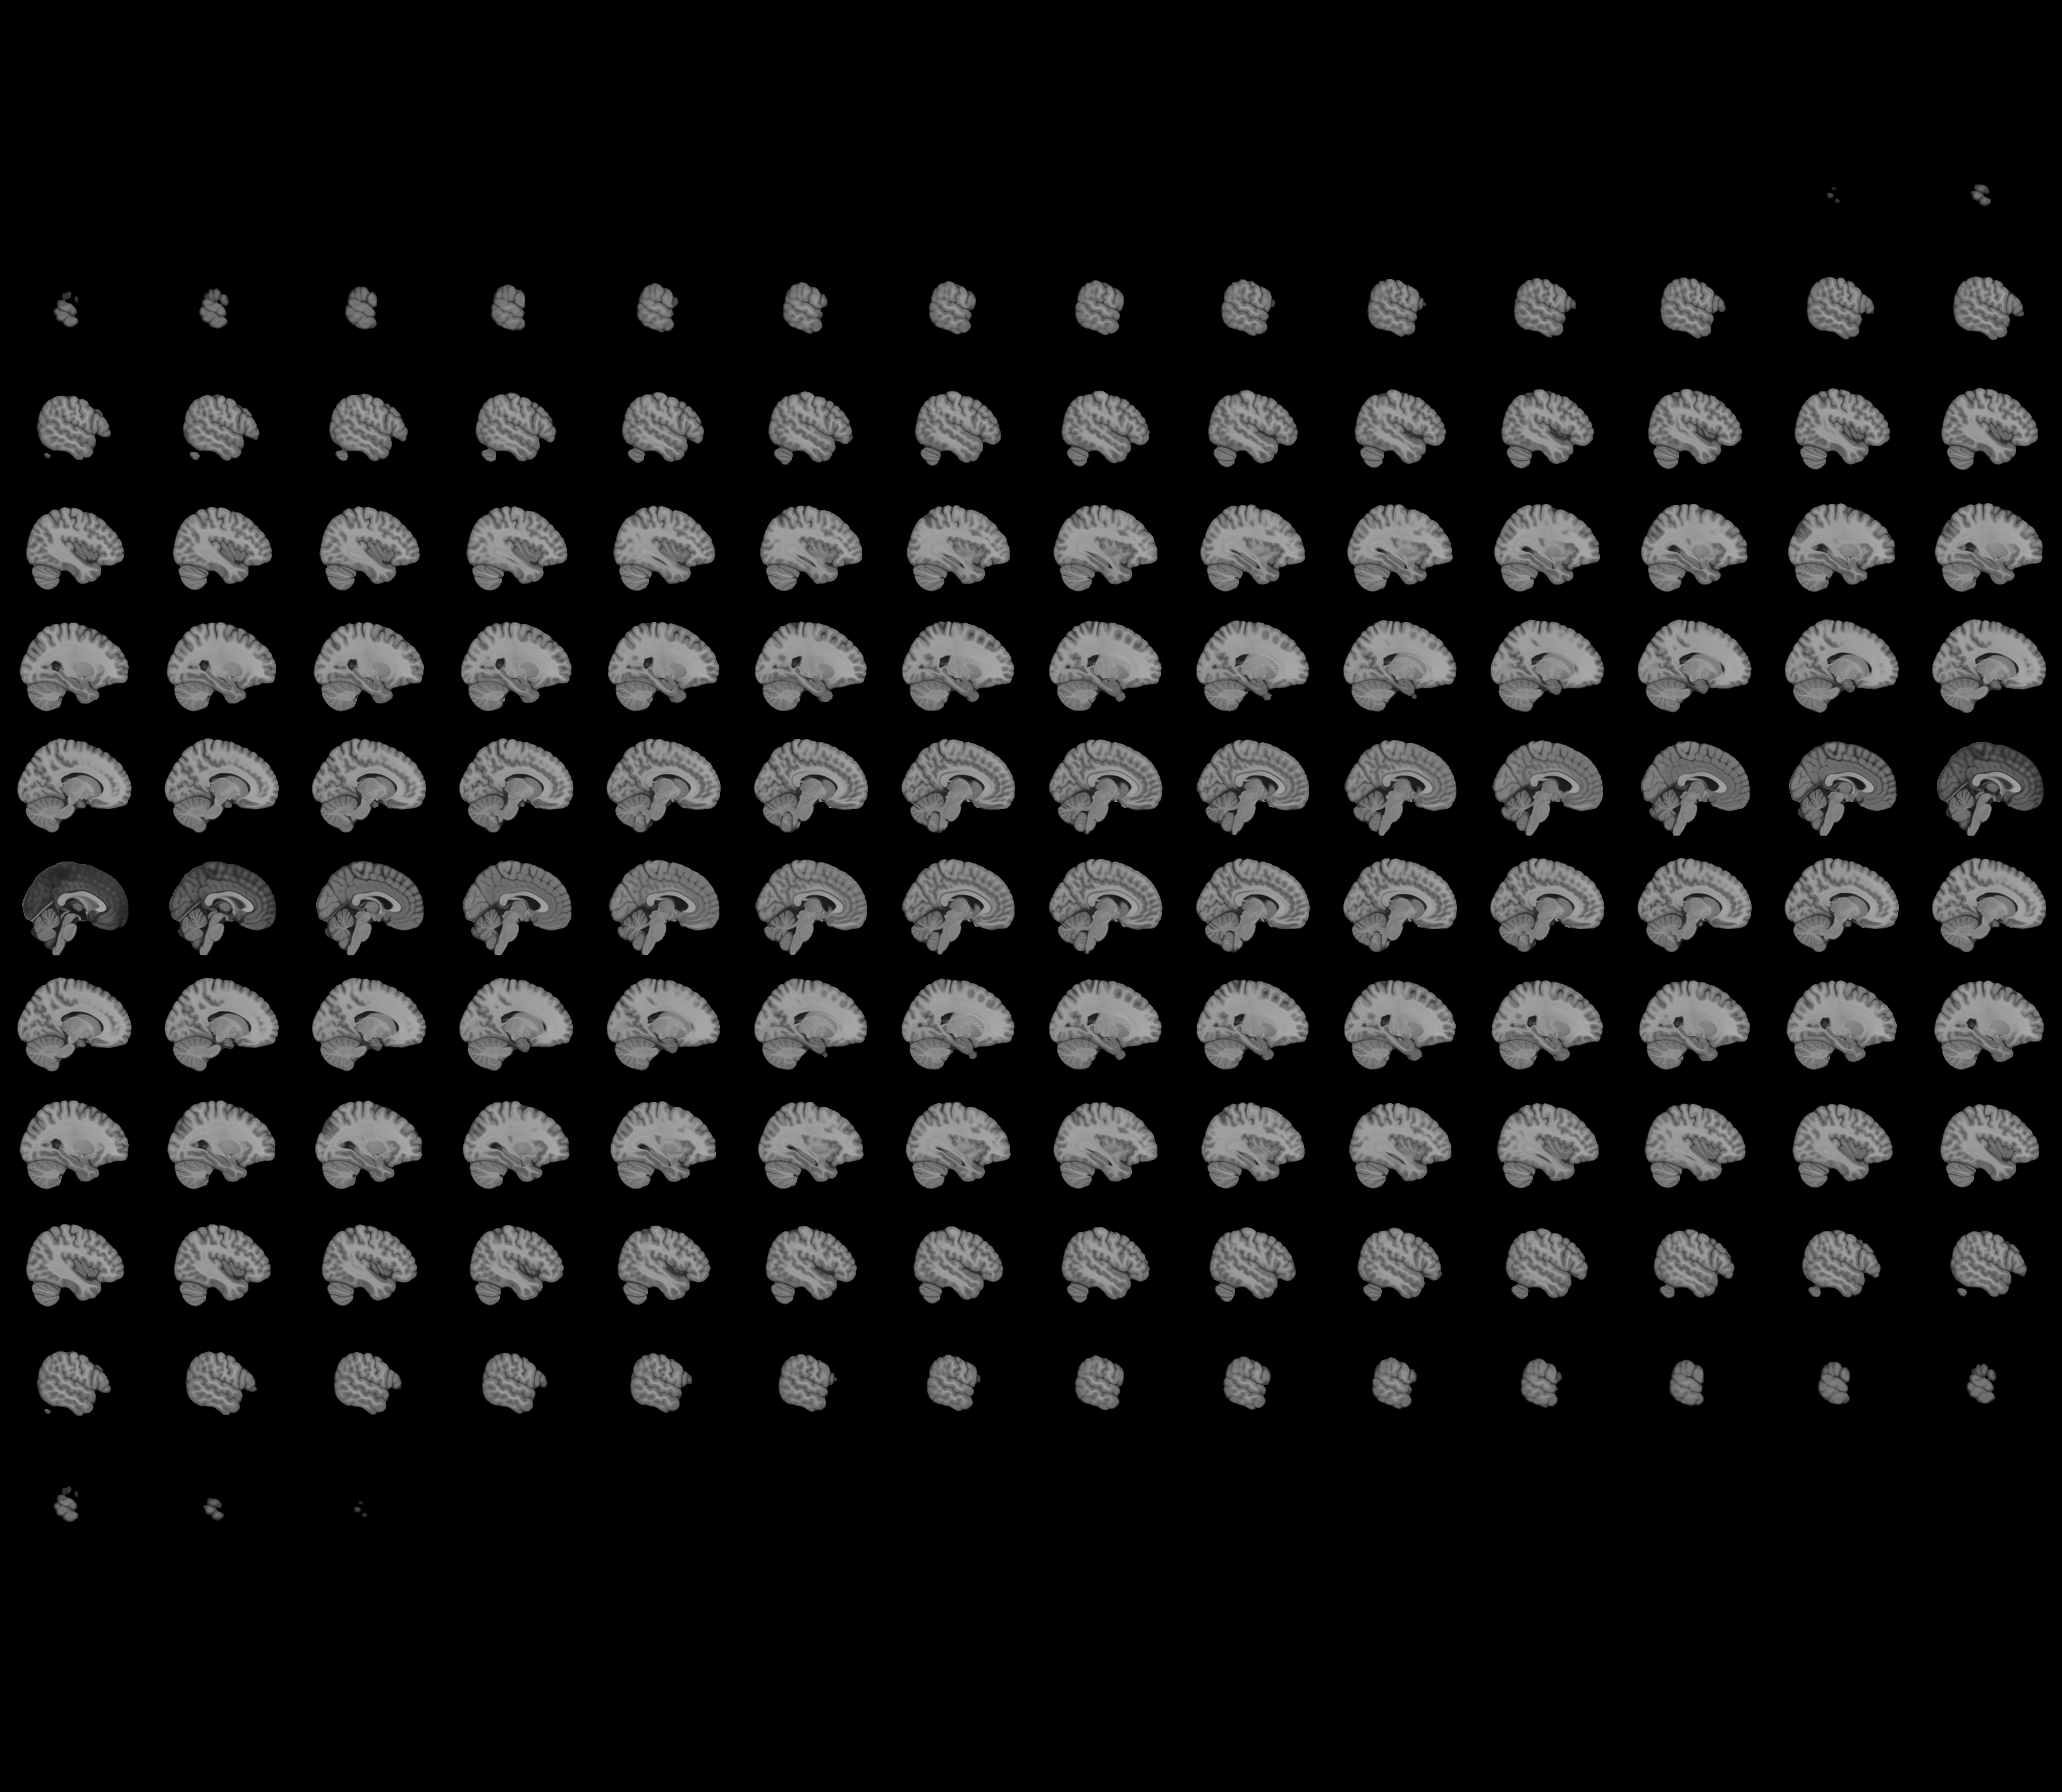
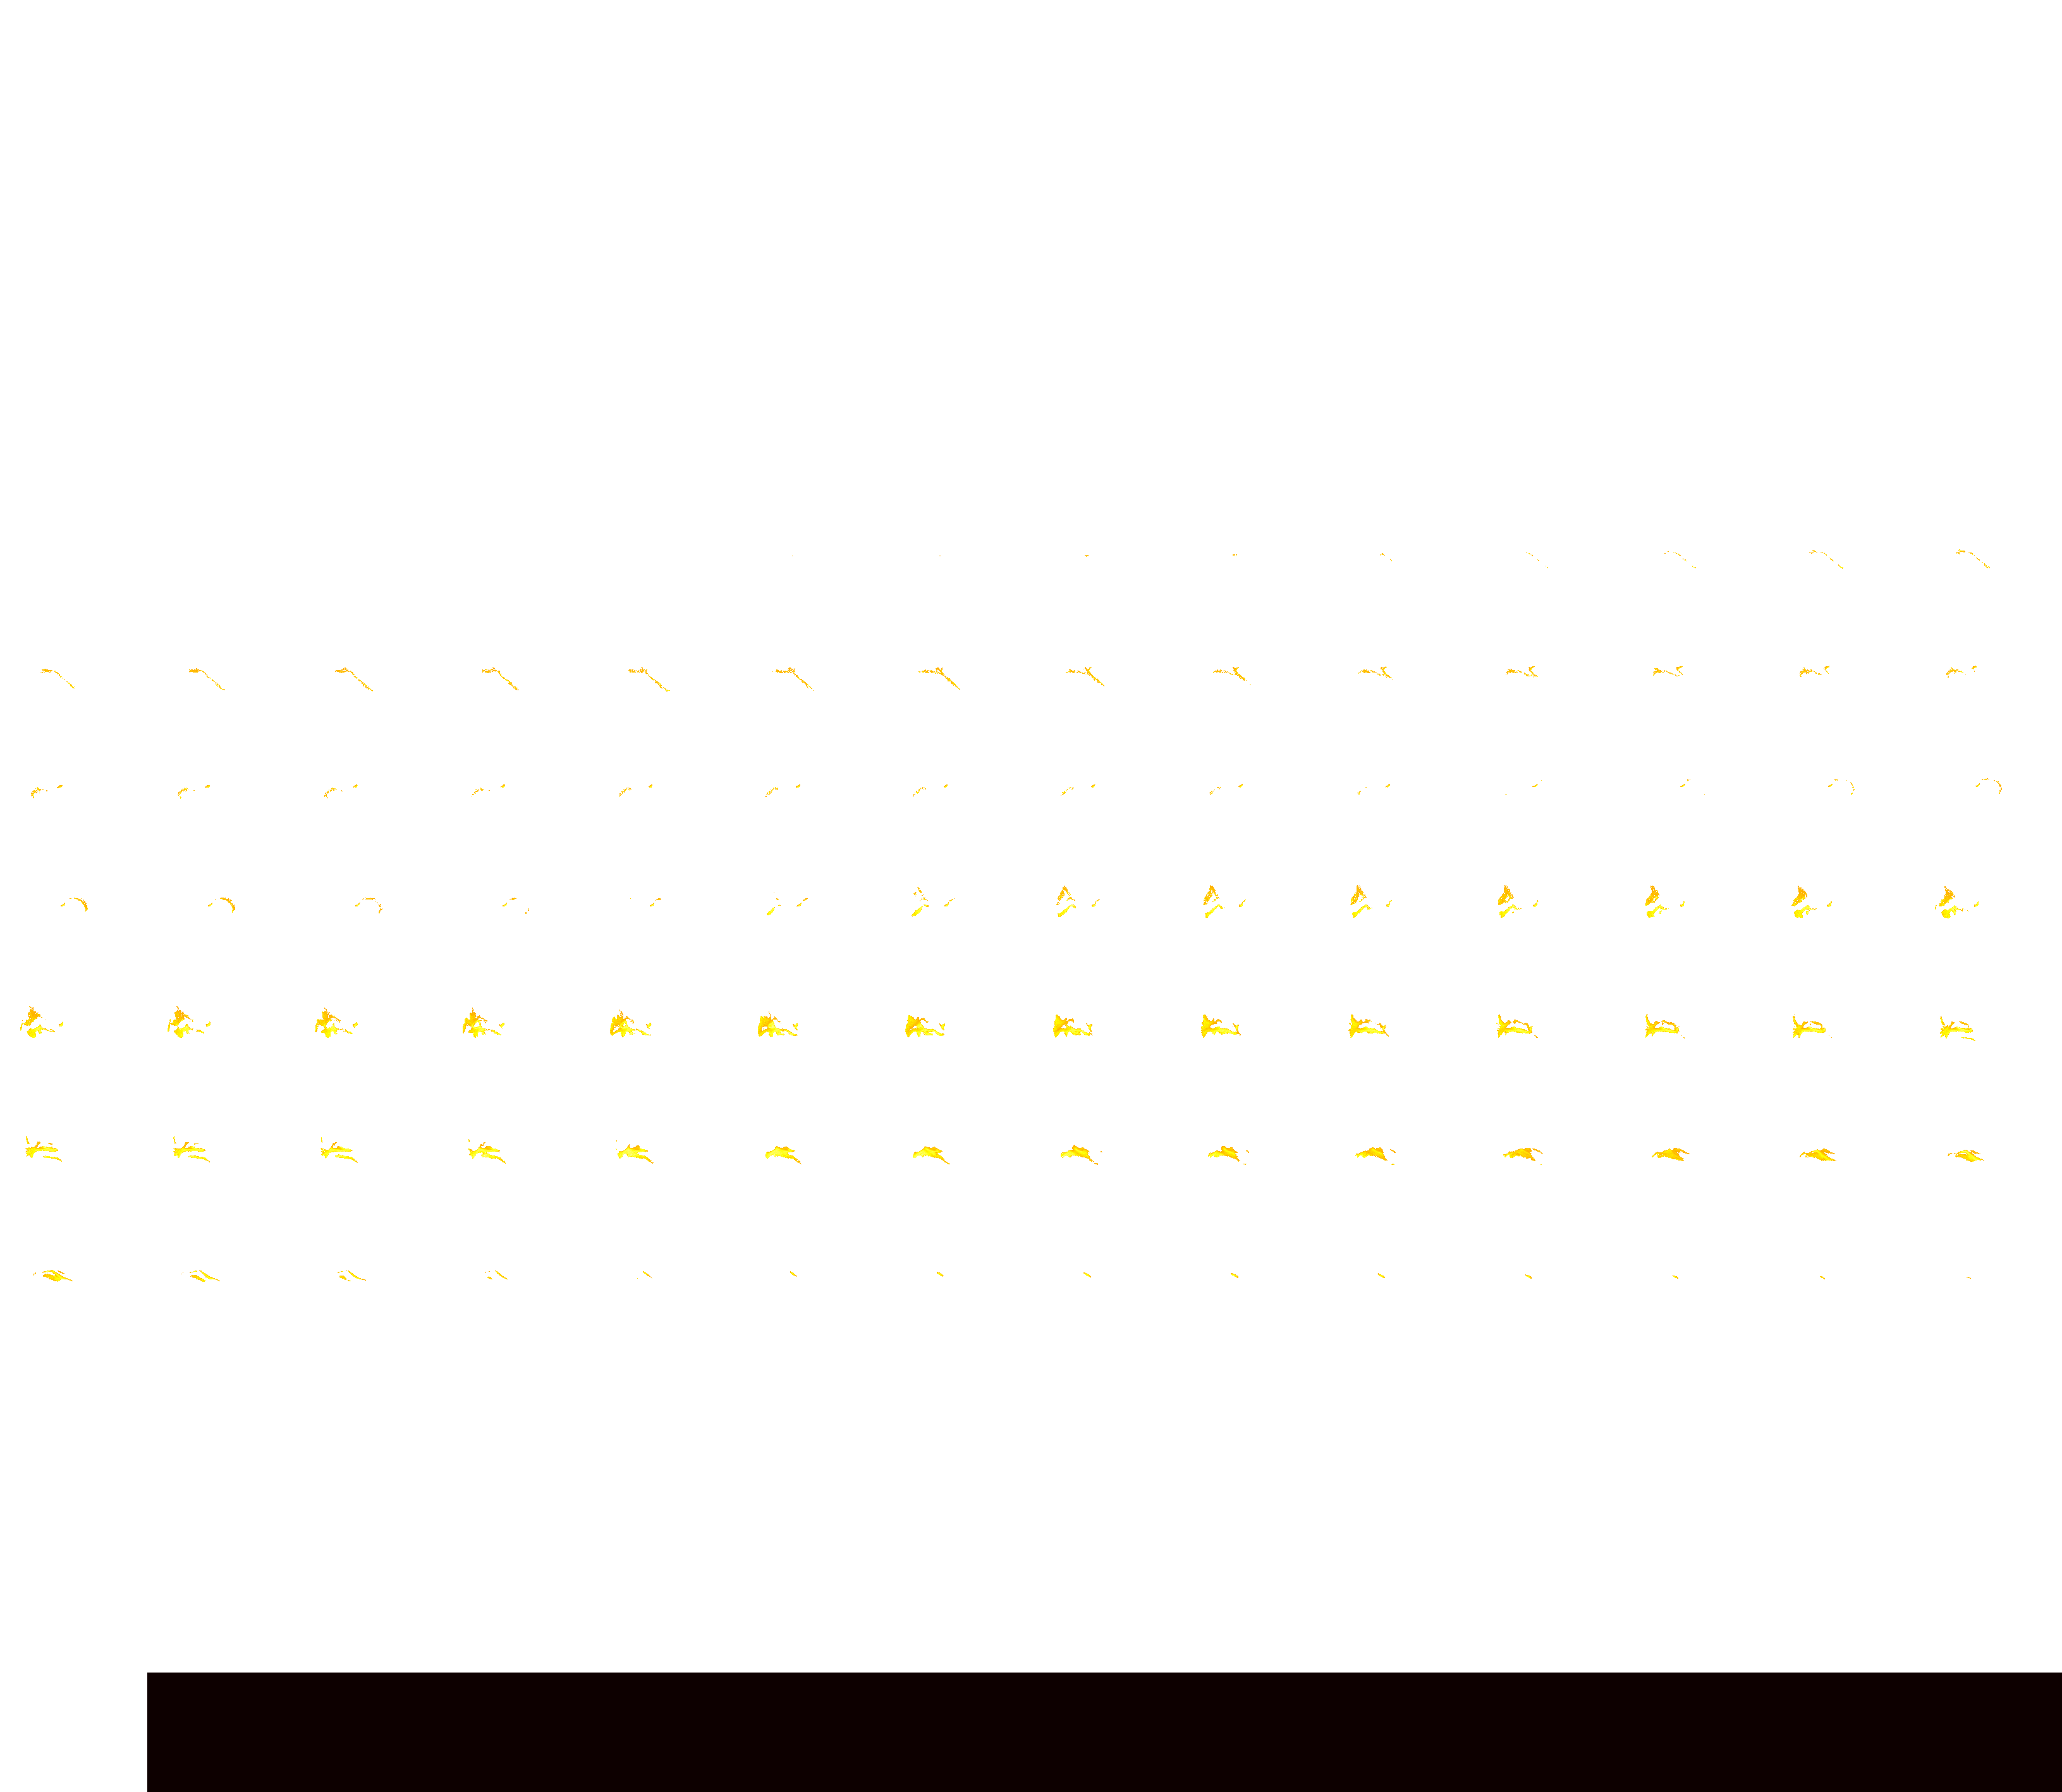

In [108]:
plotting.view_img(maskedAPMtsig)

Minimum t-value non 0: 4.1722427604168555
Max t-value: 5.715334053769782


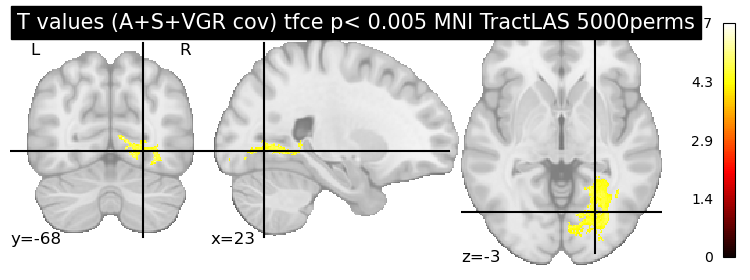

In [151]:
##create a mask of just where p vaues (I set threshold) are significant
threshold = 0.005
thresholdlog = -np.log10(threshold)
APMsigornot = np.where(olsAPM[('logp_max_tfce')]>=thresholdlog, 1,0)
##multiply the mask of significance with the tfce values so you only see tfce values when their significant 
APMtsig = APMsigornot * olsAPM[('t')]
maskedAPMtsig  = unmask(APMtsig, mask)

##Printing the minimum and Maximum non 0 t values after masking
min_nonzero = np.min(APMtsig[APMtsig > 0])
print("Minimum t-value non 0:", min_nonzero)
print("Max t-value:",np.max(APMtsig))

#Plotting the stat Map
plotting.plot_stat_map(maskedAPMtsig, title='T values (A+S+VGR cov) tfce p< '+str(threshold)+' MNI TractLAS '+str(n_perm)+'perms')
plt.show()


/home/remoteuser/kaemik/.conda/envs/nabc_tfce/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



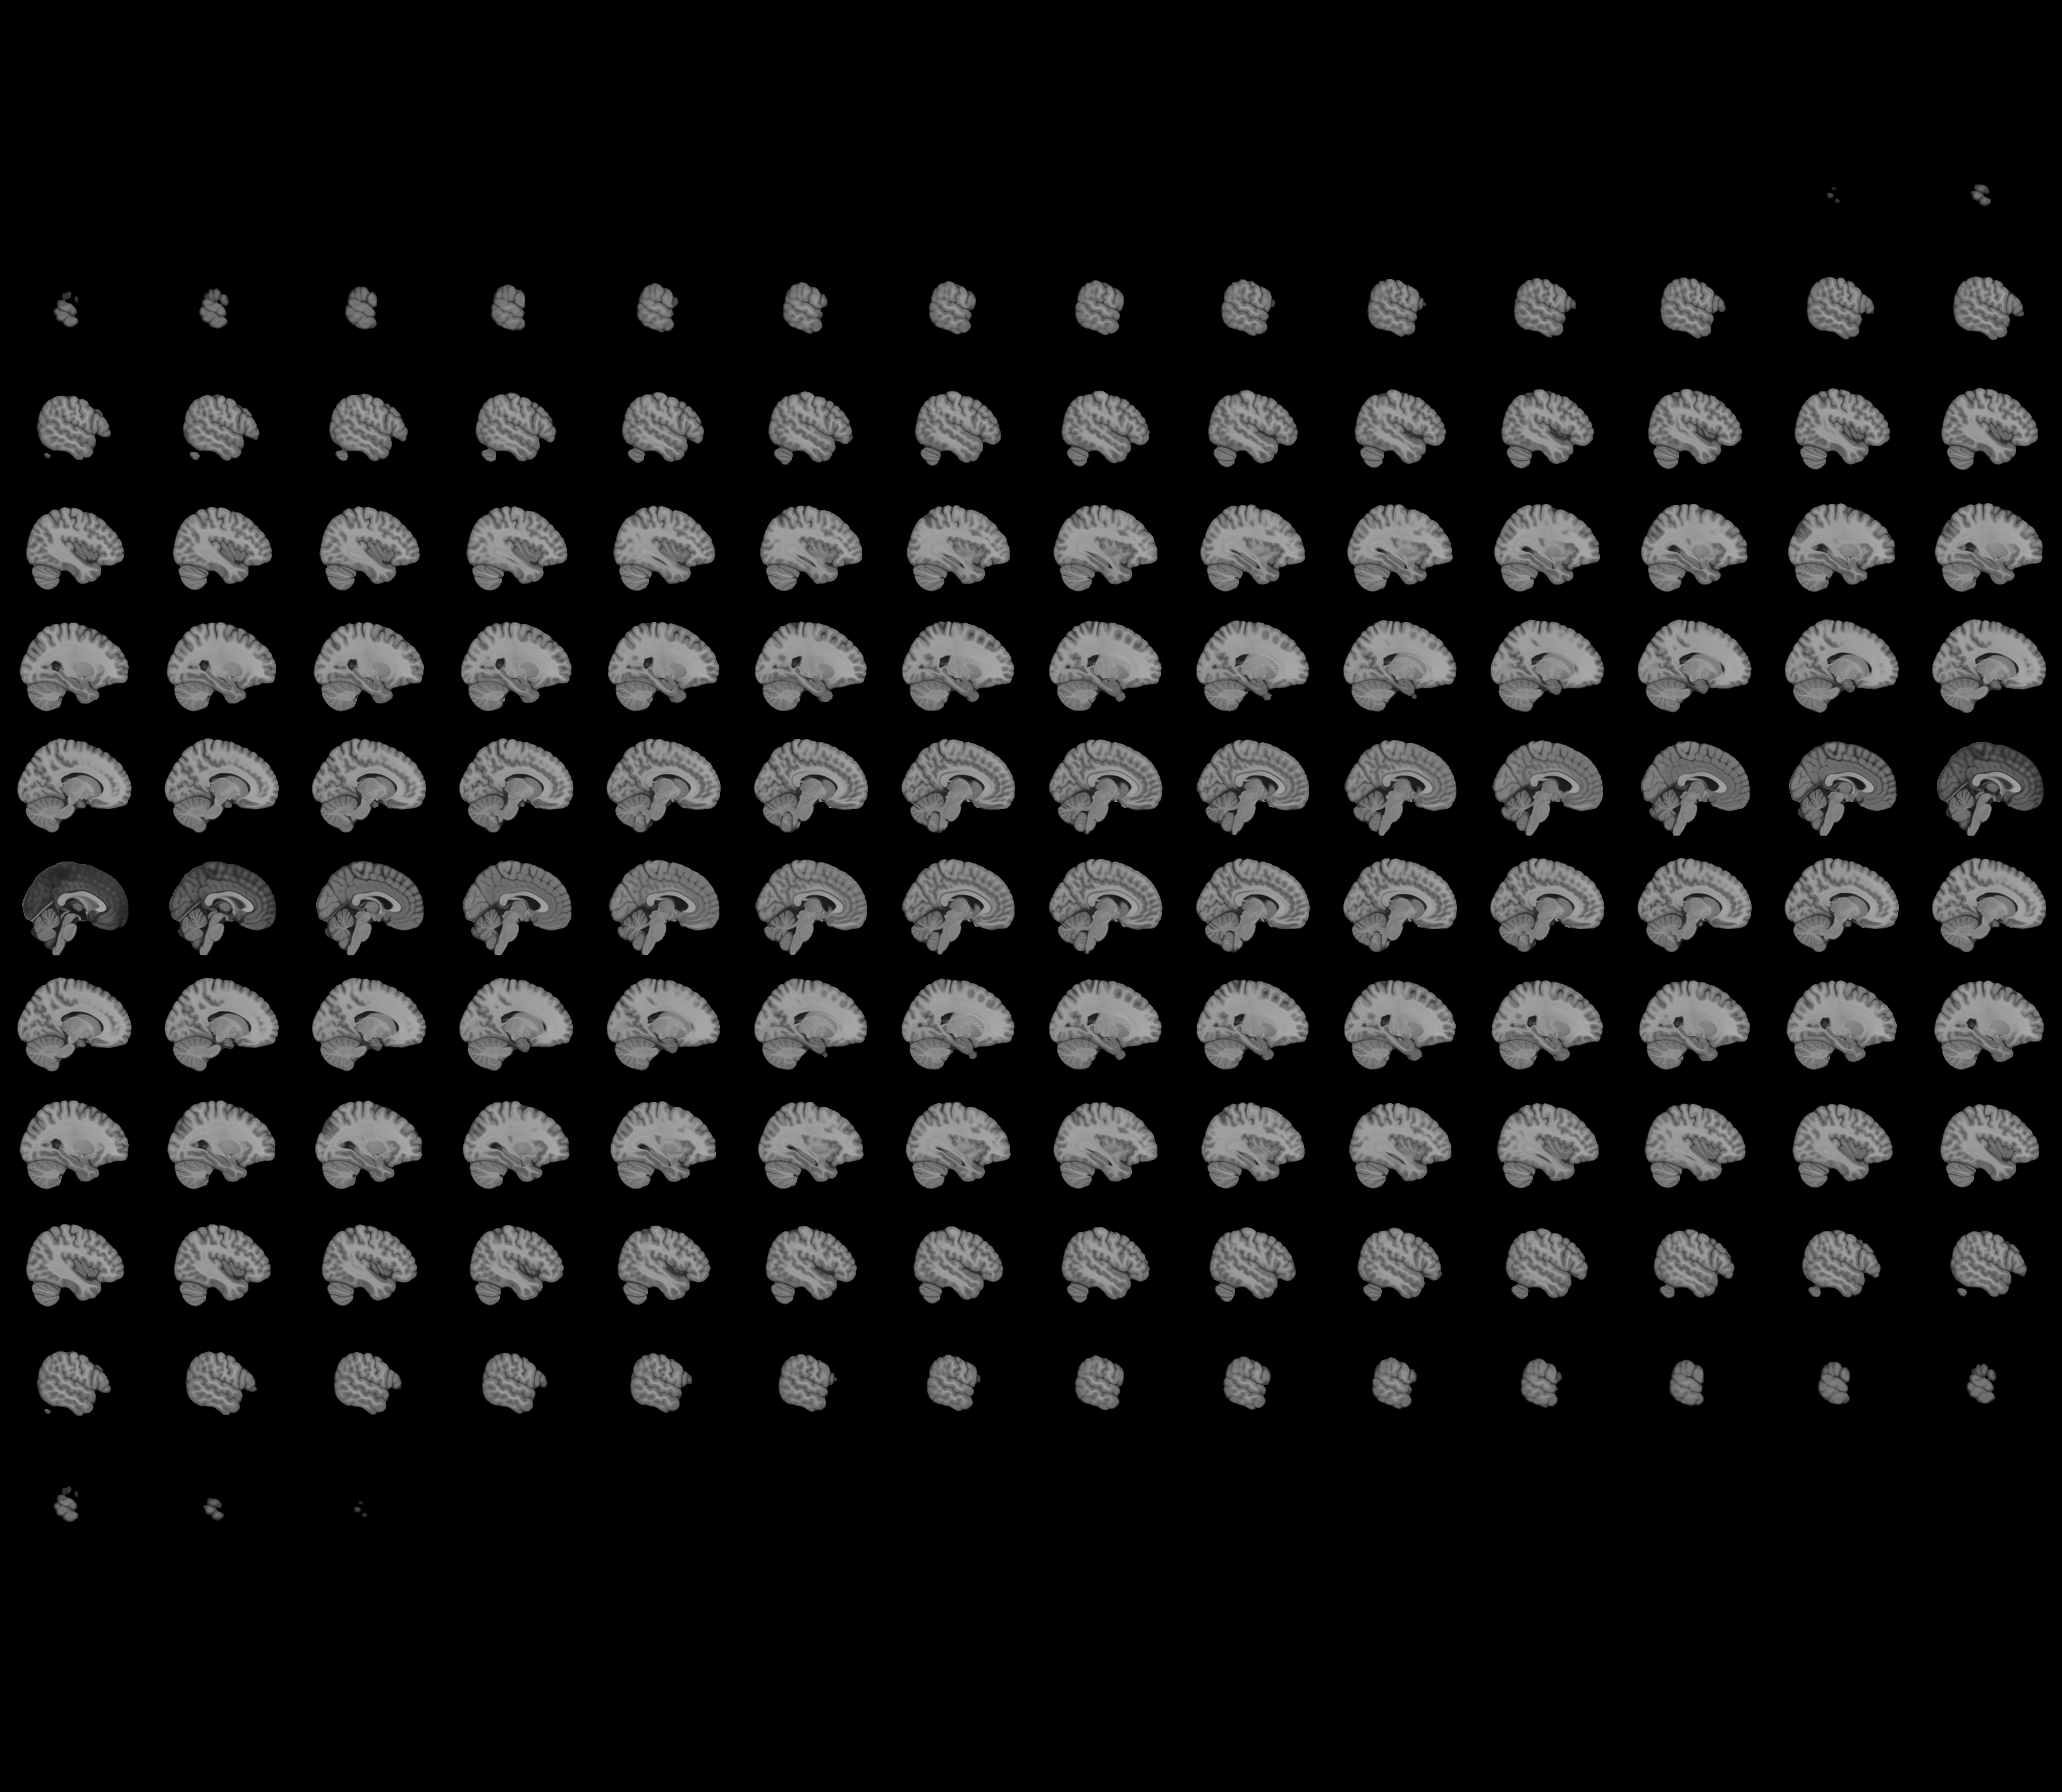
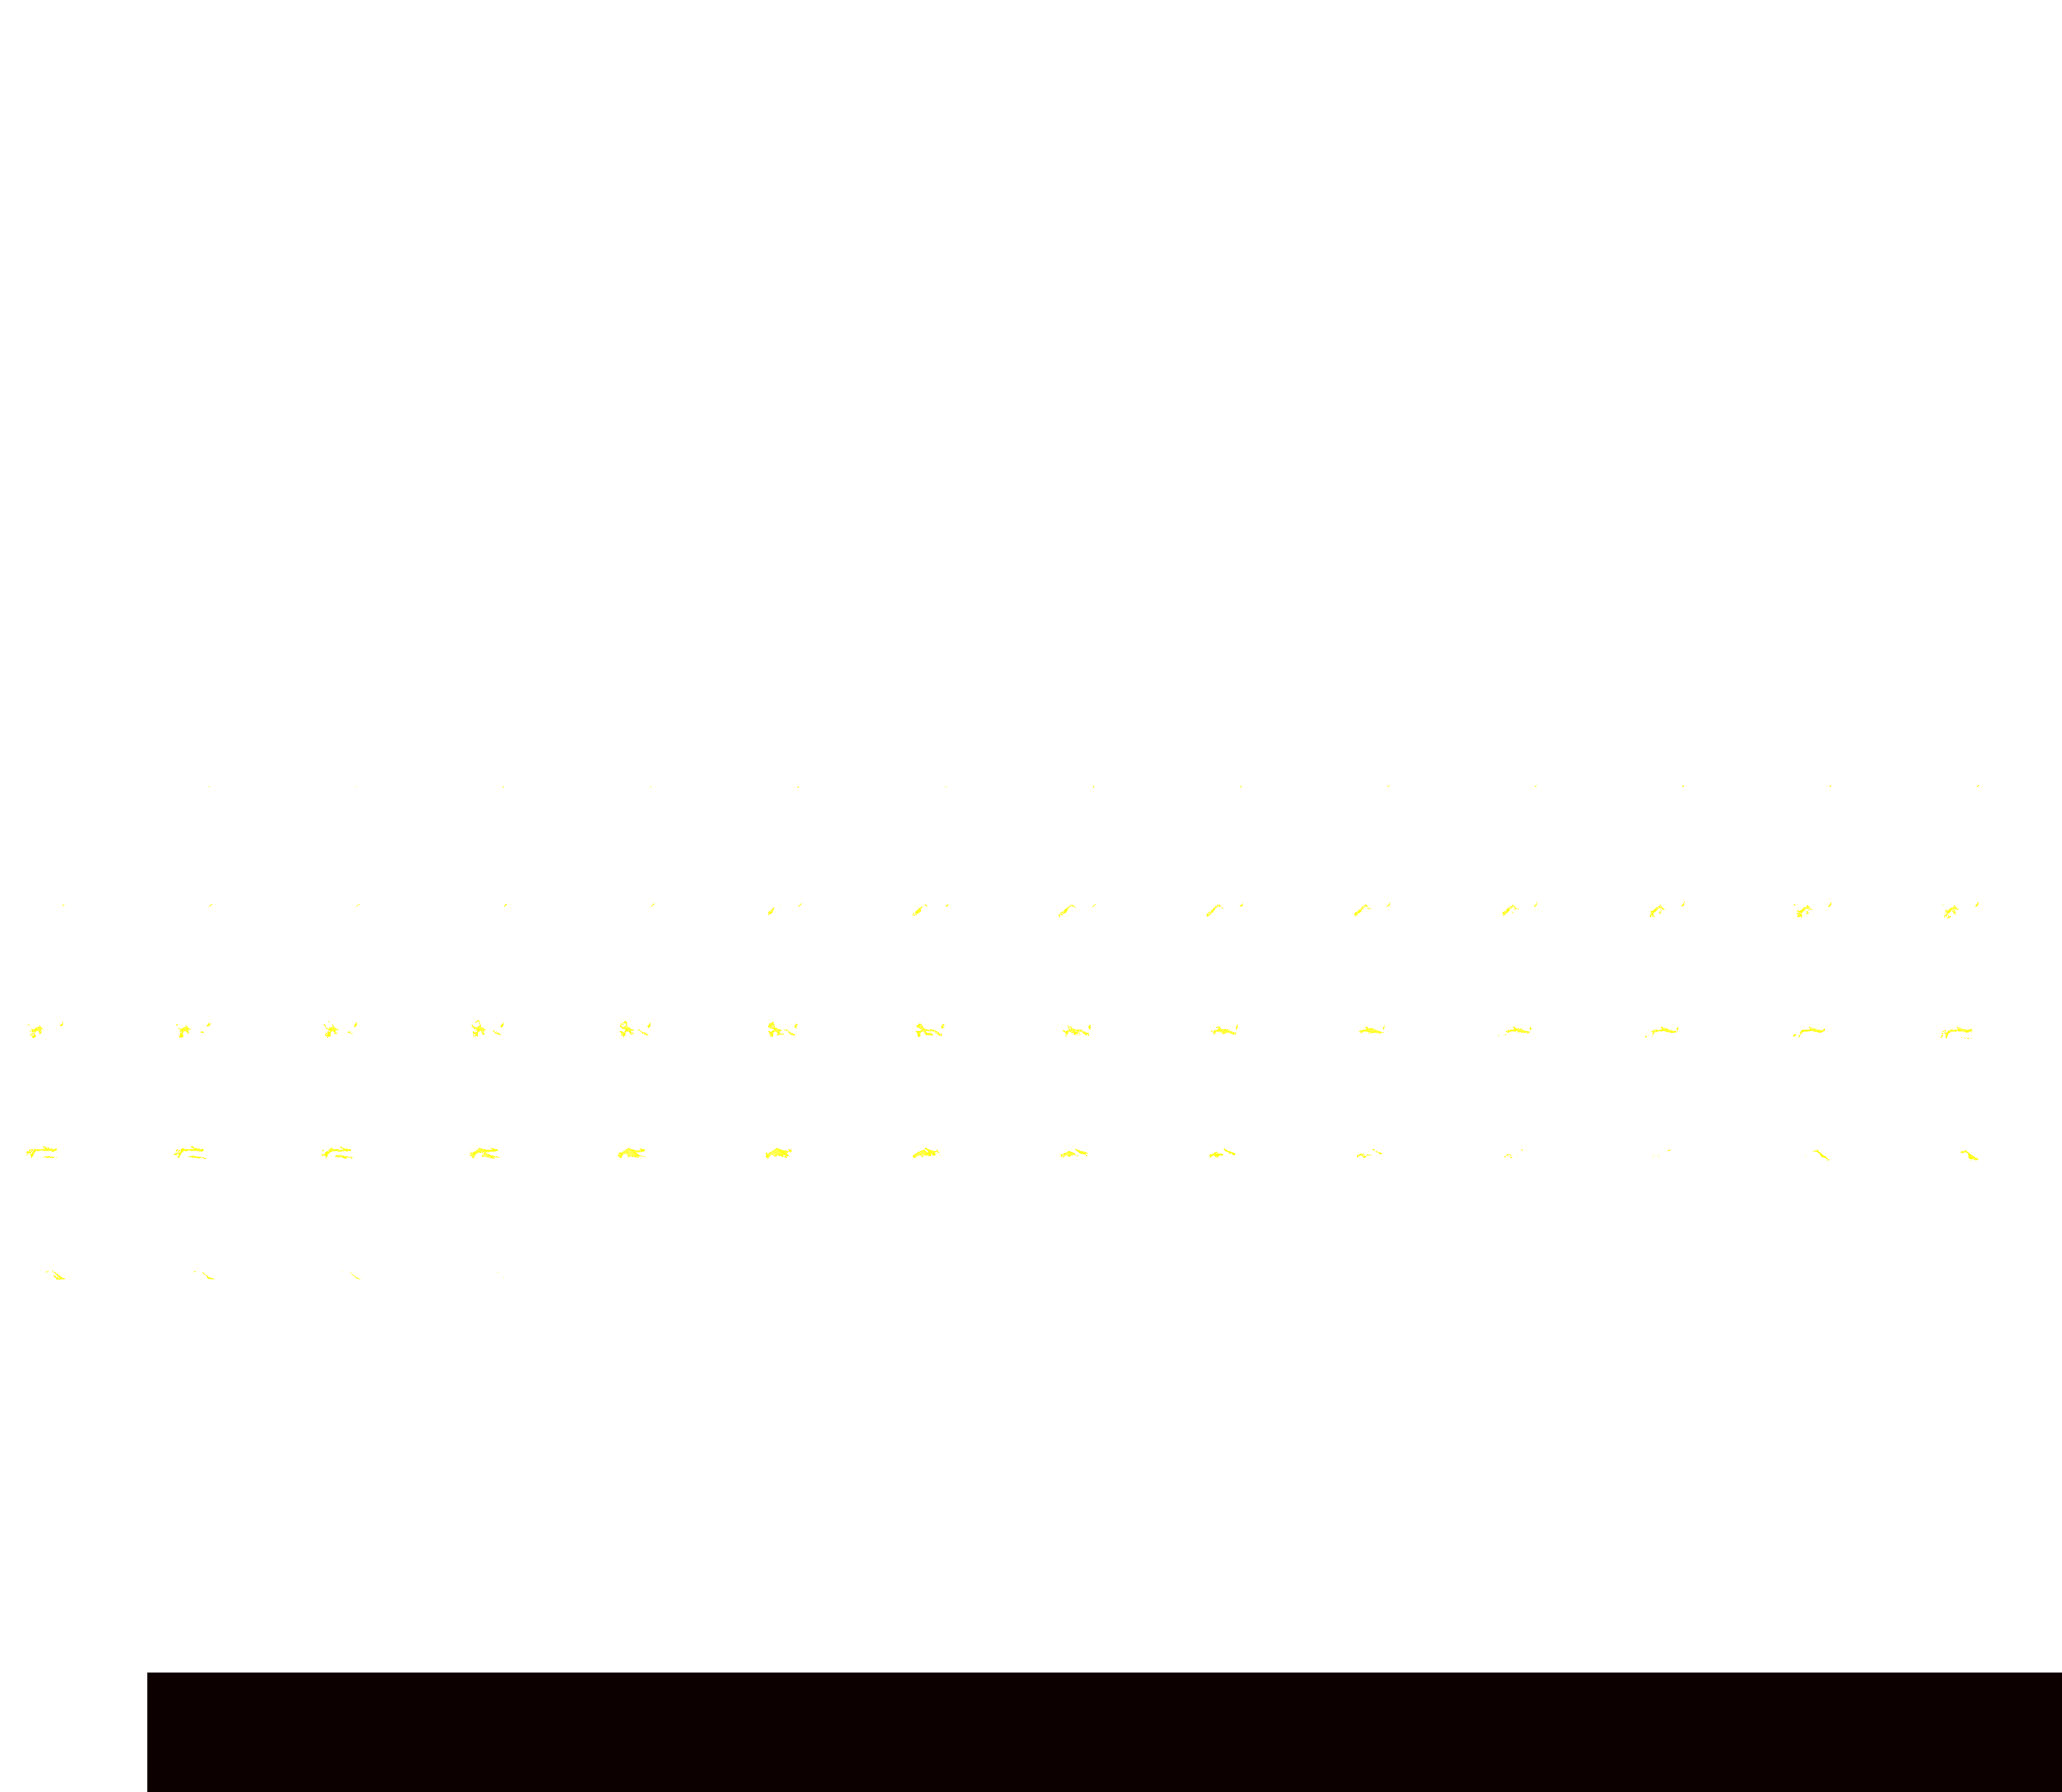

In [140]:
plotting.view_img(maskedAPMtsig)


In [152]:
### Saving only significant regions of t values based on tfce p values
out_dir='/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/'

strthresh = '0p005'

nb.save(maskedAPMtsig, out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}.nii.gz')
print('Saved to: ',out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}.nii.gz')

Saved to:  /data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TonlyTFCE_0p005.nii.gz


## **Only sig T**

In [111]:
#Looking at the min and max tfce p values to see how far I can go
print(np.log10(0.015))
print('min: ' + str((olsAPM['logp_max_t'].flatten()).min()))
print('max: ' + str((olsAPM['logp_max_t'].flatten()).max()))

-1.8239087409443189
min: -0.0
max: 1.9508688275414674


Minimum t-value non 0: 5.12462241491175
Max t-value: 5.715334053769782


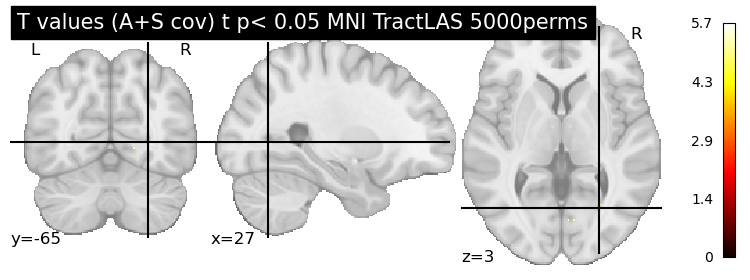

In [112]:
##create a mask of just where p vaues (I set threshold) are significant
threshold = 0.05
thresholdlog = -np.log10(threshold)
APMsigornot = np.where(olsAPM[('logp_max_t')]>=thresholdlog, 1,0)
##multiply the mask of significance with the tfce values so you only see tfce values when their significant 

APMtsig = APMsigornot * olsAPM[('t')]
maskedAPMtsig  = unmask(APMtsig, mask)

##Printing the minimum and Maximum non 0 t values after masking
min_nonzero = np.min(APMtsig[APMtsig > 0])
print("Minimum t-value non 0:", min_nonzero)
print("Max t-value:",np.max(APMtsig))

#Plotting the stat Map
plotting.plot_stat_map(maskedAPMtsig, title='T values (A+S cov) t p< '+str(threshold)+' MNI TractLAS '+str(n_perm)+'perms')
plt.show()

In [43]:
### Saving only significant regions of t values based on t p values
out_dir='/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/'

strthresh = '0p05'

# nb.save(maskedAPMtsig, out_dir+f'APMxMNIDisc_{TaskMetric}_TFCE{n_perm}perms{confst}_TonlyT_{strthresh}.nii.gz')
print('Saved to: ',out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyT_{strthresh}.nii.gz')

Saved to:  /data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_38subs_AgeSexVGR_5000perms_TonlyT_0p05.nii.gz


**Checking Number of Significant Voxels for TaskScore**

In [44]:
# APMlogpTaskscoreCov = nb.load('/data/neuralabc/kaemik/LS_StrokeDisconnect/processing/RegressionOUT/APMvsDisc_TaskScore_Affected_TFCE5000agesex_Tlogp.nii.gz').get_fdata().flatten()
# APMlogpTaskscoreTFCECov = nb.load('/data/neuralabc/kaemik/LS_StrokeDisconnect/processing/RegressionOUT/APMvsDisc_TaskScore_Affected_TFCE5000agesex_TFCElogp.nii.gz').get_fdata().flatten()
# APMlogpTaskScoreNo = nb.load('/data/neuralabc/stechr/STROMAP_CLSM/processing/disconnectome_regression/bx_APM_aff_unaff_Task_Score_affected_hand_39subs_5000perms_logp_max_t.nii.gz').get_fdata().flatten()
# APMlogpTaskScoreTFCENo = nb.load('/data/neuralabc/stechr/STROMAP_CLSM/processing/disconnectome_regression/bx_APM_aff_unaff_Task_Score_affected_hand_39subs_5000perms_logp_max_tfce.nii.gz').get_fdata().flatten()

In [113]:
vox_countTCov = (olsAPM['logp_max_t'] >= 1.3).sum()
vox_countTFCECov = (olsAPM['logp_max_tfce'] >= 1.3).sum()

print('T with covariates: {} vox greater than {}'.format(vox_countTCov, 1.3))
print('TFCE with covariates: {} vox greater than {}'.format(vox_countTFCECov, 1.3))

T with covariates: 53 vox greater than 1.3
TFCE with covariates: 198242 vox greater than 1.3


**Finding T and ES max/ min**

At the p<0.05 tfce level

In [153]:
##Finding max t value
tval_map = '/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TonlyTFCE_0p05.nii.gz'

#Unmasking nessesary data
tval_map_um = masking.apply_mask(tval_map, mask)

In [154]:
x = np.extract(tval_map_um>0,tval_map_um)

print('TFCE p values at 0.05 level')
print('T min: ',min(x))
print('T max: ',tval_map_um.max())


TFCE p values at 0.05 level
T min:  2.6862084941858213
T max:  5.715334053769782


In [155]:
####Trying to get cohens D min with min t value

sqrtN = math.sqrt(subs)

#Divide each t value in each voxel by the square root of n
cohensD = np.divide(tval_map_um, sqrtN, casting='same_kind')
D = np.extract(cohensD>0,cohensD)

print('TFCE p values at 0.05 level')
print('D min: ',min(D))
print('D max: ',max(D))

TFCE p values at 0.05 level
D min:  0.43576055938034963
D max:  0.927149612439576


In [156]:
#Saving CohensD map
out_dir='/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/'

strthresh = 'p0.05'

maskedcohensD  = unmask(cohensD, mask)
#nb.save(maskedcohensD, out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}_CohensD.nii.gz')
print('Saved to: ',out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}_CohensD.nii.gz')

Saved to:  /data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TonlyTFCE_p0.05_CohensD.nii.gz


**At the p<0.03 tfce level**

In [157]:
##Finding max t value
tval_map = '/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TonlyTFCE_0p03.nii.gz'

#Unmasking nessesary data
tval_map_um = masking.apply_mask(tval_map, mask)

In [162]:
x = np.extract(tval_map_um>0,tval_map_um)

print('TFCE p values at 0.03 level')
print('T min: ',min(x))
print('T max: ',tval_map_um.max())

TFCE p values at 0.03 level
T min:  2.9148245861715347
T max:  5.715334053769782


In [163]:
####Trying to get cohens D min with min t value

sqrtN = math.sqrt(38)

#Divide each t value in each voxel by the square root of n
cohensD = np.divide(tval_map_um, sqrtN, casting='same_kind')
D = np.extract(cohensD>0,cohensD)

print('TFCE p values at 0.03 level')
print('D min: ',min(D))
print('D max: ',max(D))

TFCE p values at 0.03 level
D min:  0.4728469867156332
D max:  0.927149612439576


In [161]:
out_dir='/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/'

strthresh = 'p0.01'

maskedcohensD  = unmask(cohensD, mask)
# nb.save(maskedcohensD, out_dir+f'APMxMNIDisc_{TaskMetric}_TFCE{n_perm}perms{confst}_TonlyTFCE_{strthresh}_CohensD.nii.gz')
print('Saved to: ',out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}_CohensD.nii.gz')

Saved to:  /data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TonlyTFCE_p0.01_CohensD.nii.gz


**At the p<0.005 level**

In [ ]:
##Finding max t value
tval_map = '/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/APMxMNIDisc_Task_Score_Aff_correct38subs_AgeSexVGR_5000perms_TonlyTFCE_0p005.nii.gz'

#Unmasking nessesary data
tval_map_um = masking.apply_mask(tval_map, mask)

In [ ]:
x = np.extract(tval_map_um>0,tval_map_um)

print('TFCE p values at 0.005 level')
print('T min: ',min(x))
print('T max: ',tval_map_um.max())


In [ ]:
####Trying to get cohens D min with min t value

sqrtN = math.sqrt(subs)

#Divide each t value in each voxel by the square root of n
cohensD = np.divide(tval_map_um, sqrtN, casting='same_kind')
D = np.extract(cohensD>0,cohensD)

print('TFCE p values at 0.005 level')
print('D min: ',min(D))
print('D max: ',max(D))

In [ ]:
#Saving CohensD map
out_dir='/data/neuralabc/kaemik/MNI_StrokeDisconnect/processing/RegressionOUT/'

strthresh = '0p005'

maskedcohensD  = unmask(cohensD, mask)
#nb.save(maskedcohensD, out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}_CohensD.nii.gz')
print('Saved to: ',out_dir+f'APMxMNIDisc_{TaskMetric}_correct{subs}subs_{confst}_{n_perm}perms_TonlyTFCE_{strthresh}_CohensD.nii.gz')

Correlating both

In [67]:
TSra_valid = np.asarray(TSra, dtype=float).flatten()
VGR_valid = np.asarray(np.array(vgrdemo['* - Task Score_affected_hand']), dtype=float).flatten()

In [68]:
# Create a DataFrame for correlation
corr_df = pd.DataFrame({
    "APM": TSra_valid,
    "VGR": VGR_valid
})

# Correlation matrix
corr_matrix = corr_df.corr()

# Display result
print(corr_matrix)

          APM       VGR
APM  1.000000  0.441867
VGR  0.441867  1.000000
